In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import omegaconf

In [2]:
query = """
WITH subset AS (
    SELECT app_id FROM game
    TABLESAMPLE BERNOULLI (20)
)
SELECT
    subset.app_id,
    game_tag.tag_id,
    tag.name
FROM subset
JOIN game_tag ON subset.app_id = game_tag.app_id
JOIN tag ON game_tag.tag_id = tag.tag_id
"""

db_params = omegaconf.OmegaConf.load("configs/db_params.yaml")

with psycopg2.connect(**db_params) as conn: # type: ignore
    conn: psycopg2.extensions.connection
    with conn.cursor() as cur:
        cur.execute(query)
        result = cur.fetchall()

df = pd.DataFrame(result, columns=["app_id", "tag_id", "tag"])
df.head()

,app_id,tag_id,tag
0,218230,269086,Adventure
1,218230,269091,First-Person
2,218230,269103,Open World
3,218230,269104,FPS
4,218230,269105,+


In [3]:
data_matrix = pd.crosstab(df["app_id"], df["tag"])
print("Density:", data_matrix.sum().sum() / data_matrix.size)
print("Shape:", data_matrix.shape)
data_matrix

Density: 0.029690771068725447
Shape: (1921, 417)


tag,+,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
app_id,,,,,,,,,,,,,,,,,,,,,
20,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
360,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1530,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1610,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1840,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557890,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559010,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559450,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
sns.set_style("whitegrid")

<Axes: xlabel='tag', ylabel='app_id'>

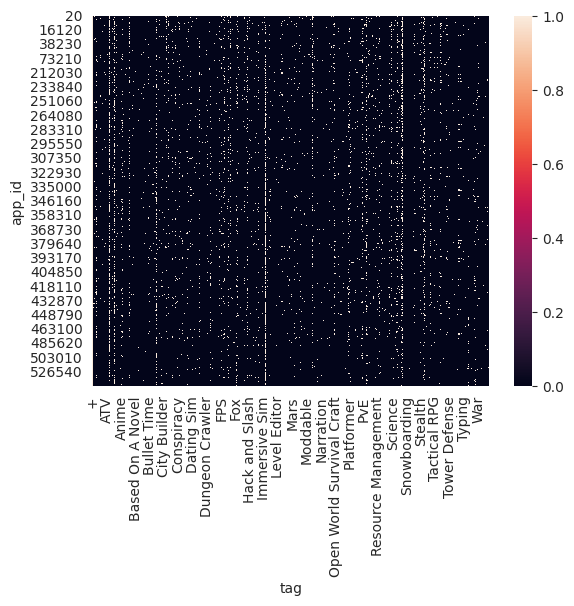

In [5]:
sns.heatmap(data_matrix)

Рассмотрим распространенные теги, за исключением нескольких самых популярных:

('Multiplayer', 6.025865973825314)
('2D', 6.021023349349527)
('RPG', 5.986452005284438)
('Simulation', 5.958424693029782)
('Atmospheric', 5.823045895483019)
('Puzzle', 5.811140992976701)
('Great Soundtrack', 5.771441123130016)
('Story Rich', 5.58724865840025)
('Shooter', 5.5254529391317835)
('Platformer', 5.4638318050256105)
('Funny', 5.44673737166631)
('Sci-fi', 5.41610040220442)
('Pixel Graphics', 5.4116460518550396)
('Fantasy', 5.402677381872279)
('Co-op', 5.393627546352362)
('Difficult', 5.389071729816501)
('First-Person', 5.3612921657094255)
('Female Protagonist', 5.356586274672012)
('Open World', 5.308267697401205)
('Arcade', 5.272999558563747)
('Horror', 5.267858159063328)
('Retro', 5.2574953720277815)
('Free to Play', 5.117993812416755)
('Anime', 5.062595033026967)
('Third Person', 5.056245805348308)
('Classic', 5.0369526024136295)
('Point & Click', 5.0369526024136295)
('Exploration', 5.0369526024136295)
('Comedy', 5.030437921392435)
('Survival', 5.003946305945459)
('Early Acce

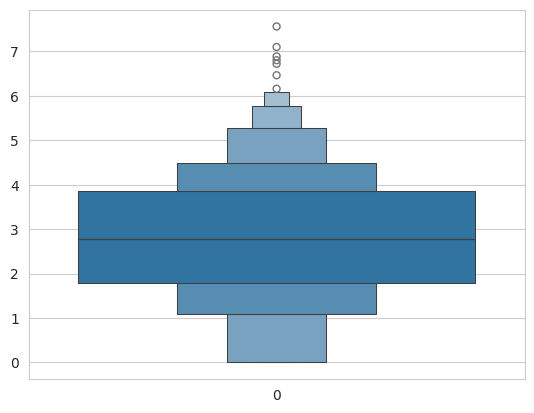

In [6]:
tag_count = data_matrix.sum(axis=0)
log_total: pd.Series = np.log(tag_count)
max = log_total.quantile(1-1/64)
min = log_total.quantile(1-1/8)
idx: pd.Series = (min <= log_total) & (log_total <= max)

filtered = log_total[idx].sort_values(ascending=False)
columns = filtered.index

sns.boxenplot(pd.DataFrame(log_total))
for i in zip(columns, filtered):
    print(i)


<Axes: xlabel='tag', ylabel='tag'>

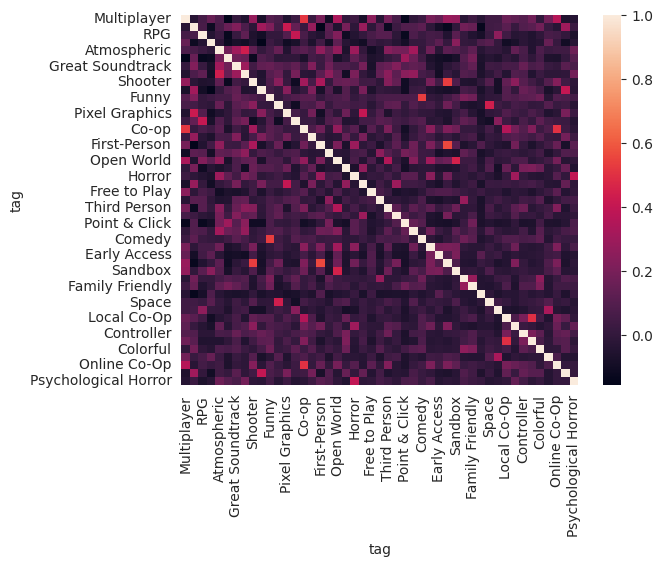

In [7]:
corr_matrix = (data_matrix[columns]).corr()
sns.heatmap(corr_matrix)

1 ['Atmospheric', 'Puzzle', 'Story Rich', 'Female Protagonist', 'Point & Click', 'Exploration', 'Psychological Horror']
2 ['Multiplayer', 'Sci-fi', 'Co-op', 'Open World', 'Third Person', 'Survival', 'VR', 'Space', 'Online Co-Op']
3 ['2D', 'Platformer', 'Pixel Graphics', 'Difficult', 'Arcade', 'Retro', 'Local Co-Op', 'Controller', 'Local Multiplayer', 'Side Scroller']
4 ['Shooter', 'First-Person', 'Horror', 'FPS', 'Gore']
5 ['RPG', 'Fantasy', 'Turn-Based']
6 ['Great Soundtrack', 'Funny', 'Anime', 'Classic', 'Comedy', 'Cute', 'Family Friendly', 'Colorful']
7 ['Simulation', 'Free to Play', 'Early Access', 'Sandbox', 'Tactical']


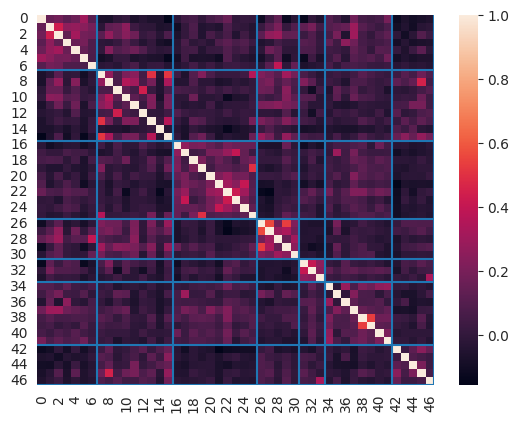

In [9]:
import sklearn.cluster

n_clusters = 7
model = sklearn.cluster.SpectralCoclustering(n_clusters=n_clusters).fit(corr_matrix.to_numpy())
fit_data = corr_matrix.to_numpy()[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
ax = sns.heatmap(fit_data)
pos = 0

for i in range(n_clusters):
    cluster = list(columns[model.column_labels_ == i])
    pos += len(cluster)
    ax.hlines(y=pos, xmin=0, xmax=len(columns))
    ax.vlines(x=pos, ymin=0, ymax=len(columns))
    print(i+1, cluster)

По совместной встречаемости видим, что разметка тегов скорее всего корректная, и на ней можно обучить модель